In [19]:
import os
import numpy as np
import pandas as pd
import torch
import shap
import umap
import re
import nltk

from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import zscore

import matplotlib.pyplot as plt

from lime.lime_tabular import LimeTabularExplainer

from nltk.corpus import stopwords

In [2]:
MODEL_NAME = "bert-base-multilingual-cased" 
BATCH_SIZE = 16
MAX_LENGTH = 128
RANDOM_STATE = 42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
def clean_tweet(tweet):
    # Convertendo para minúsculas
    tweet = tweet.lower()
    
    # Removendo URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Removendo menções (@usuário)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Removendo caracteres especiais, exceto espaços, letras e números
    tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet)
    
    # Removendo múltiplos espaços
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
        
    return tweet

In [7]:
train_df = pd.read_csv(
    "data/twitter_training.csv",
    header=None,
    names=["id", "topic", "sentiment", "text"],
)
val_df = pd.read_csv(
    "data/twitter_validation.csv",
    header=None,
    names=["id", "topic", "sentiment", "text"],
)

In [8]:
train_df.drop_duplicates(subset=['text'], inplace=True)
val_df.drop_duplicates(subset=['text'], inplace=True)

In [9]:
train_df['text'] = train_df['text'].fillna("").apply(clean_tweet)
val_df['text']   = val_df['text'].fillna("").apply(clean_tweet)

In [10]:
keep = ["Positive", "Negative"]
train_df = train_df[train_df["sentiment"].isin(keep)].reset_index(drop=True)
val_df = val_df[val_df["sentiment"].isin(keep)].reset_index(drop=True)


In [11]:
train_df

,id,topic,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
40228,9200,Nvidia,Positive,just realized that the windows partition of my...
40229,9200,Nvidia,Positive,just realized that my mac window partition is ...
40230,9200,Nvidia,Positive,just realized the windows partition of my mac ...
40231,9200,Nvidia,Positive,just realized between the windows partition of...


In [12]:
le = LabelEncoder()
y_train = le.fit_transform(train_df["sentiment"])  # Positive→1, Negative→0
y_val = le.transform(val_df["sentiment"])

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\Users\T-Gamer\miniconda3\envs\recommender-system\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\T-Gamer\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [14]:
def embed_texts(texts, batch_size=BATCH_SIZE, max_length=MAX_LENGTH):
    all_embs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size].tolist()
            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            ).to(device)

            out = model(**enc)  
            cls_emb = out.last_hidden_state[:, 0, :] 
            cls_emb = cls_emb.cpu().numpy()
            all_embs.append(cls_emb)
    return np.vstack(all_embs)

In [15]:
print("Embedding training texts...")
X_train = embed_texts(train_df["text"])
print("Embedding validation texts...")
X_val = embed_texts(val_df["text"])

Embedding training texts...
Embedding validation texts...


In [16]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced",
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Classification Report (Validation):
              precision    recall  f1-score   support

    Negative       0.91      0.95      0.93       266
    Positive       0.95      0.91      0.93       276

    accuracy                           0.93       542
   macro avg       0.93      0.93      0.93       542
weighted avg       0.93      0.93      0.93       542

ROC AUC (validation): 0.9873


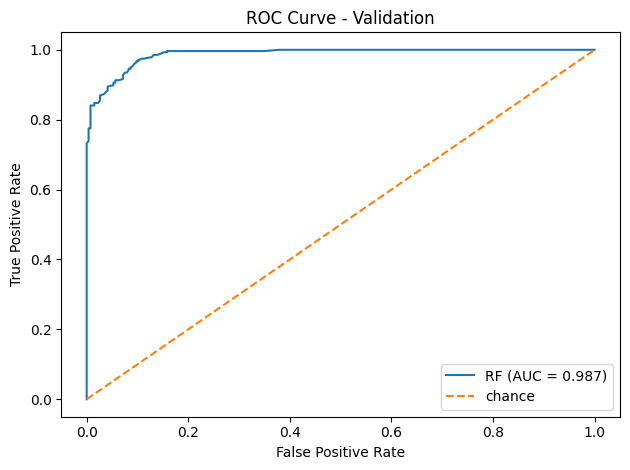

In [17]:
y_pred = rf.predict(X_val)
y_proba = rf.predict_proba(X_val)[:, 1]  # probability for positive class

print("Classification Report (Validation):")
print(classification_report(y_val, y_pred, target_names=le.classes_))

try:
    roc_auc = roc_auc_score(y_val, y_proba)
    print(f"ROC AUC (validation): {roc_auc:.4f}")
except Exception as e:
    print(f"Could not compute ROC AUC: {e}")

fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation")
plt.legend()
plt.tight_layout()
plt.show()

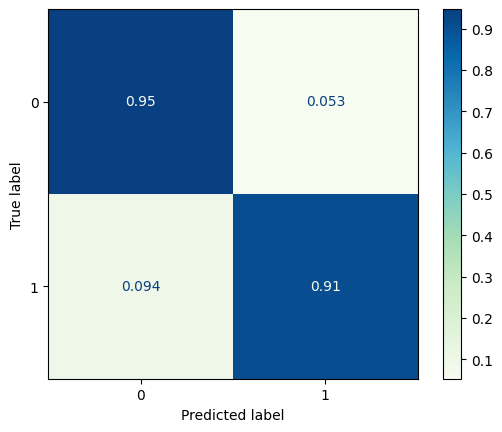

In [26]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.GnBu)
plt.grid(False)
plt.show()

The figure layout has changed to tight


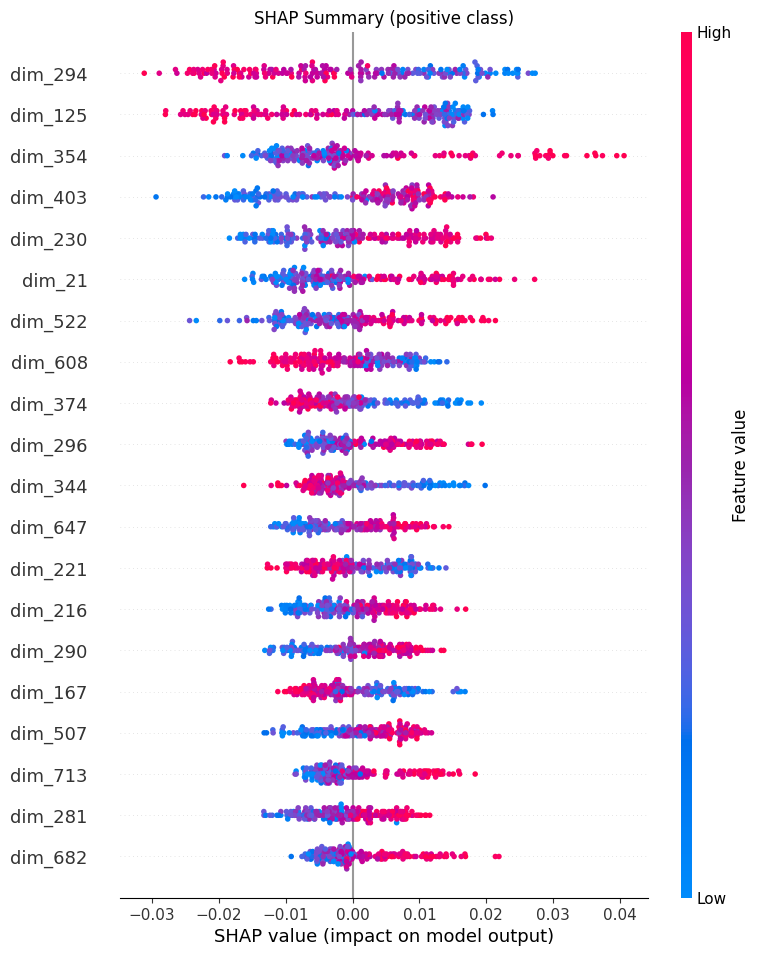

In [73]:
explainer = shap.TreeExplainer(rf)
sample_idx = np.random.RandomState(RANDOM_STATE).choice(
    np.arange(X_val.shape[0]), size=min(200, X_val.shape[0]), replace=False
)
X_shap = X_val[sample_idx]
shap_values = explainer.shap_values(X_shap)  # list if multiclass

plt.figure()
shap.summary_plot(
    shap_values[1],
    X_shap,
    feature_names=[f"dim_{i}" for i in range(X_shap.shape[1])],
    show=False,
)
plt.tight_layout()
plt.title("SHAP Summary (positive class)"); 
plt.show()

Explaining example index 360 (true label: Negative)


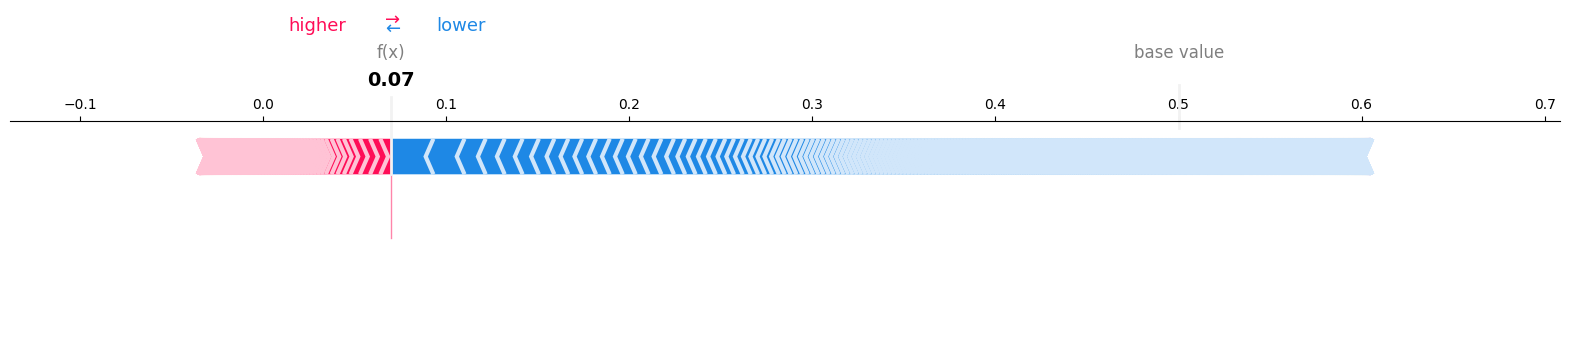

In [74]:
idx = sample_idx[0]
print(f"Explaining example index {idx} (true label: {le.inverse_transform([y_val[idx]])[0]})")
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    matplotlib=True,
    feature_names=[f"dim_{i}" for i in range(X_shap.shape[1])],
)

In [75]:
def compute_permutation_importance(model, X, y, scoring="roc_auc", n_repeats=10, random_state=42):
    result = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=-1,
    )
    importances = result.importances_mean  # shape (n_features,)
    return importances, result

In [76]:
def get_top_dims(shap_values_pos_class, perm_importances, top_k=30, threshold_permutation=None):
    """
    shap_values_pos_class: array (n_samples, n_dims) for positive class, use mean absolute
    perm_importances: array (n_dims,) from permutation_importance
    """
    mean_abs_shap = np.abs(shap_values_pos_class).mean(axis=0)
    top_shap_idx = np.argsort(mean_abs_shap)[::-1][: top_k]
    if threshold_permutation is None:
        top_perm_idx = np.argsort(perm_importances)[::-1][: top_k]
    else:
        top_perm_idx = np.where(perm_importances >= threshold_permutation)[0]
    intersect = np.intersect1d(top_shap_idx, top_perm_idx)
    return {
        "top_shap": top_shap_idx,
        "top_perm": top_perm_idx,
        "intersection": intersect,
        "mean_abs_shap": mean_abs_shap,
        "perm_importances": perm_importances,
    }

In [77]:
def explain_dim_with_text(
    dim_idx,
    embedding_array,  
    texts,  
    shap_values_pos_class,
    percentile_high=80,
    percentile_low=20,
    ngram_range=(1, 2),
    top_n_terms=15,
):
    """
    Para uma dimensão específica do embedding, pega exemplos onde ela está alta vs baixa
    e extrai termos discriminativos por diferença média de TF-IDF.
    """
    dim_vals = embedding_array[:, dim_idx]
    # normaliza para robustez
    z_vals = zscore(dim_vals)
    high_mask = z_vals >= np.percentile(z_vals, percentile_high)
    low_mask = z_vals <= np.percentile(z_vals, percentile_low)

    if high_mask.sum() < 5 or low_mask.sum() < 5:
        return {"dim": dim_idx, "warning": "poucos exemplos em high/low"}

    texts_high = texts[high_mask].tolist()
    texts_low = texts[low_mask].tolist()
    combined_texts = texts_high + texts_low
    labels = np.array([1] * len(texts_high) + [0] * len(texts_low))  

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=2)
    tfidf_mat = vectorizer.fit_transform(combined_texts) 
    feature_names = np.array(vectorizer.get_feature_names_out())

    mean_high = tfidf_mat[labels == 1].mean(axis=0).A1  
    mean_low = tfidf_mat[labels == 0].mean(axis=0).A1

    diff = mean_high - mean_low  

    top_high_idx = np.argsort(diff)[::-1][:top_n_terms]
    top_low_idx = np.argsort(diff)[:top_n_terms]

    explanation = {
        "dim": dim_idx,
        "high_examples_count": int(high_mask.sum()),
        "low_examples_count": int(low_mask.sum()),
        "top_terms_when_dim_high": feature_names[top_high_idx].tolist(),
        "top_terms_when_dim_low": feature_names[top_low_idx].tolist(),
        "shap_effect_direction": np.sign(
            np.mean(shap_values_pos_class[:, dim_idx])
        ),  
    }
    return explanation

In [78]:
def analyze_embedding_text_correlation(
    rf,
    X_val,
    y_val,
    val_texts,  
    shap_values_pos_class,
    top_k=30,
    n_dims_to_explain=5,
):
    perm_importances, perm_raw = compute_permutation_importance(rf, X_val, y_val)
    tops = get_top_dims(shap_values_pos_class, perm_importances, top_k=top_k)
    intersect = tops["intersection"]
    if len(intersect) == 0:
        print("Nenhuma dimensão em comum entre top SHAP e top permutation. Pegando top SHAP.")
        dims_to_do = tops["top_shap"][:n_dims_to_explain]
    else:
        dims_to_do = list(intersect[:n_dims_to_explain])
        if len(dims_to_do) < n_dims_to_explain:
            extra = [d for d in tops["top_shap"] if d not in dims_to_do]
            dims_to_do += extra[: (n_dims_to_explain - len(dims_to_do))]
        dims_to_do = np.array(dims_to_do, dtype=int)

    explanations = []
    for dim in dims_to_do:
        expl = explain_dim_with_text(
            dim,
            X_val,
            val_texts,
            shap_values_pos_class,
        )
        explanations.append(expl)

    rows = []
    for e in explanations:
        if "warning" in e:
            rows.append(
                {
                    "dim": e["dim"],
                    "note": e["warning"],
                    "top_terms_high": None,
                    "top_terms_low": None,
                    "shap_direction": None,
                }
            )
        else:
            rows.append(
                {
                    "dim": e["dim"],
                    "note": "",
                    "top_terms_high": ", ".join(e["top_terms_when_dim_high"][:5]),
                    "top_terms_low": ", ".join(e["top_terms_when_dim_low"][:5]),
                    "shap_direction": "positive"
                    if e["shap_effect_direction"] > 0
                    else "negative",
                }
            )
    summary_df = pd.DataFrame(rows)
    return {
        "permutation_importance": perm_importances,
        "tops": tops,
        "detailed_explanations": explanations,
        "summary_table": summary_df,
    }

In [79]:
result = analyze_embedding_text_correlation(
    rf=rf,
    X_val=X_val,
    y_val=y_val,
    val_texts=val_df["text"],
    shap_values_pos_class=shap_values[1],  
    top_k=50,
    n_dims_to_explain=6,
)

# ver resumo rápido
print(result["summary_table"])

   dim note                     top_terms_high  \
0   32               fuck, god, you, smh, when   
1  125        wtf, cant, your, cant wait, wait   
2  170                 me, you, shit, to, just   
3  191         this is, is, was, god, fortnite   
4  216       wow, god, hearthstone, shit, fuck   
5  221                   not, and, it, on, wow   

                                 top_terms_low shap_direction  
0            to, really, my, time, apexlegends       positive  
1           this, this is, love, fucking, nice       negative  
2                  this, of, this is, game, so       negative  
3              to, love, my, microsoft, really       negative  
4                      the, and, you, of, that       positive  
5  this is, fucking, we, borderlands, fortnite       positive  


In [80]:
import pprint
pprint.pprint(result["detailed_explanations"][0])

{'dim': 32,
 'high_examples_count': 109,
 'low_examples_count': 109,
 'shap_effect_direction': 1.0,
 'top_terms_when_dim_high': ['fuck',
                             'god',
                             'you',
                             'smh',
                             'when',
                             'great',
                             'been',
                             'please',
                             'cause',
                             'from',
                             'fix',
                             'gonna',
                             'not',
                             'no',
                             'game'],
 'top_terms_when_dim_low': ['to',
                            'really',
                            'my',
                            'time',
                            'apexlegends',
                            'borderlands',
                            'best',
                            'next',
                            'as',
            

In [81]:
def cluster_high_dim_texts(
    dim_idx,
    X_embeddings,
    texts,              
    shap_values_pos_class,
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    n_clusters=4,
    percentile_high=80,
    random_state=42,
):
    from scipy.stats import zscore
    dim_vals = X_embeddings[:, dim_idx]
    z_vals = zscore(dim_vals)
    mask_high = z_vals >= np.percentile(z_vals, percentile_high)
    if mask_high.sum() < 10:
        raise ValueError(f"Too few high examples for dim {dim_idx}: {mask_high.sum()}")

    emb_high = X_embeddings[mask_high]
    texts_high = texts[mask_high].reset_index(drop=True)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state,
    )
    proj = reducer.fit_transform(emb_high) 

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(proj)

    df = pd.DataFrame({
        "text": texts_high,
        "umap_1": proj[:,0],
        "umap_2": proj[:,1],
        "cluster": cluster_labels,
        "dim_value": dim_vals[mask_high],
    })

    # Plot
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(df["umap_1"], df["umap_2"], c=df["cluster"], cmap="tab10", alpha=0.7, s=30)
    plt.title(f"UMAP + KMeans (dim_{dim_idx} high)")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.legend(*scatter.legend_elements(), title="cluster")
    plt.tight_layout()
    plt.show()

    return df  # for manual inspection

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


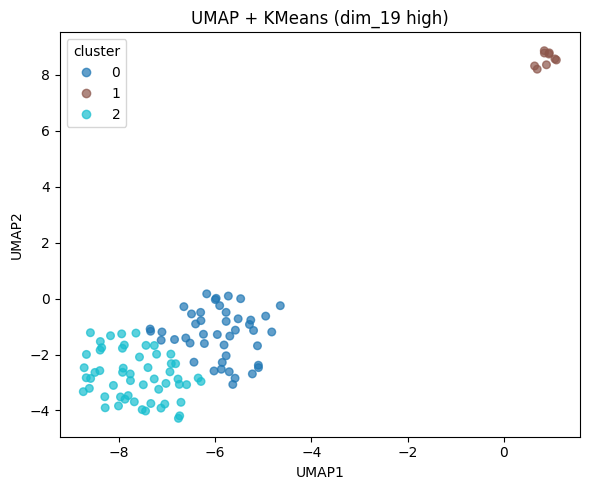


=== Cluster 0 examples (dim_19 high) ===
- im happy with this change games have a beginning middle and end its all about flow you should have to keep momentum to streak a second time not depend on streaks to get you more streaks
- ive never been this tierd in my entire life leagueoflegends struggle pictwittercompvi9sx4c7w
- man nothing makes me feel dumber than trying to play hearthstone

=== Cluster 1 examples (dim_19 high) ===
- delighted to see fifa supporting the who in the fight against covid19 they want to pass the message to kick out coronavirus handselbowfacedistancefeel washawayviruses staysafe youtubeztl5ajdb48
- so yesterday i decided to go back to overwatch and i forgot just how much i loved playing it now all i want to do is play it and do nothing else i mean the event is on atm gotta get me that pharah ski
- congrats to the nvidia nemo team for the 100 release candidate really excited to see nemo embracing hydra as the way to take control over the configuration madness t

In [82]:
df_cluster = cluster_high_dim_texts(
    dim_idx=19,
    X_embeddings=X_val,
    texts=val_df["text"],
    shap_values_pos_class=shap_values[1],  
    n_clusters=3
)

for c in sorted(df_cluster["cluster"].unique()):
    print(f"\n=== Cluster {c} examples (dim_19 high) ===")
    sample = df_cluster[df_cluster["cluster"] == c]["text"].sample(3, random_state=0).tolist()
    for t in sample:
        print("-", t.replace("\n"," ")[:200])

In [83]:
def get_representative_indices(
    dim_idx,
    X_embeddings,
    shap_values_pos_class,
    y_true,
    top_n=3,
):
    shap_contrib = shap_values_pos_class[:, dim_idx]  
    abs_contrib = np.abs(shap_contrib)
    top_idx = np.argsort(abs_contrib)[::-1][: top_n]
    return top_idx

In [84]:
def show_force_plots_for_dim(
    dim_idx,
    X_val,
    y_val,
    val_texts,
    shap_values_pos_class,
    explainer,
    n_examples=3,
):
    idxs = get_representative_indices(dim_idx, X_val, shap_values_pos_class, y_val, top_n=n_examples)
    for i in idxs:
        print(f"\n--- Example index {i}, true label: {le.inverse_transform([y_val[i]])[0]} ---")
        print("Text:", val_texts.iloc[i][:300].replace("\n"," "))
        # force plot (matplotlib)
        shap.force_plot(
            explainer.expected_value[1],
            shap_values_pos_class[i],
            feature_names=[f"dim_{j}" for j in range(X_val.shape[1])],
            matplotlib=True,
            show=True,
        )

In [85]:
lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=[f"dim_{i}" for i in range(X_train.shape[1])],
    class_names=le.classes_,
    discretize_continuous=False,
    random_state=42,
)

In [86]:
def show_lime_for_example(idx, rf, X_val, val_texts):
    print(f"\nLIME explanation for index {idx}, text: {val_texts.iloc[idx][:250].replace(chr(10),' ')}")
    exp = lime_explainer.explain_instance(
        X_val[idx],
        rf.predict_proba,
        num_features=10,
        top_labels=1,
    )
    exp.show_in_notebook(show_table=True)

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


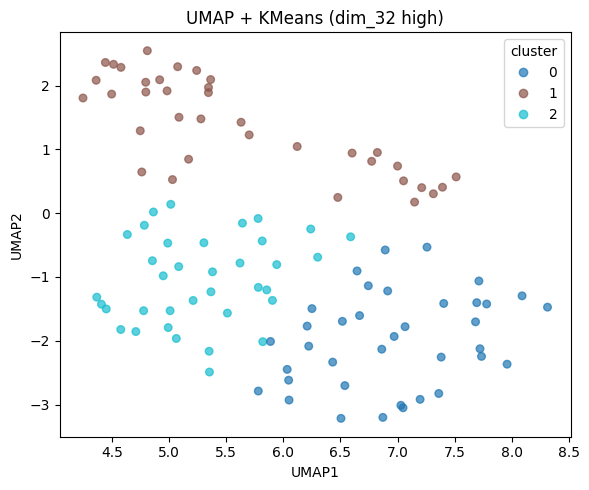


--- Example index 70, true label: Negative ---
Text: hey why is my internet speed 360mbps down327mbps up when i pay for 1gig symmetric services verizonfios fiosfail speedtest fiosfam test is performed over a wired connection with cat8 sftp 40gb cables speedtestnetresultc7cf7b


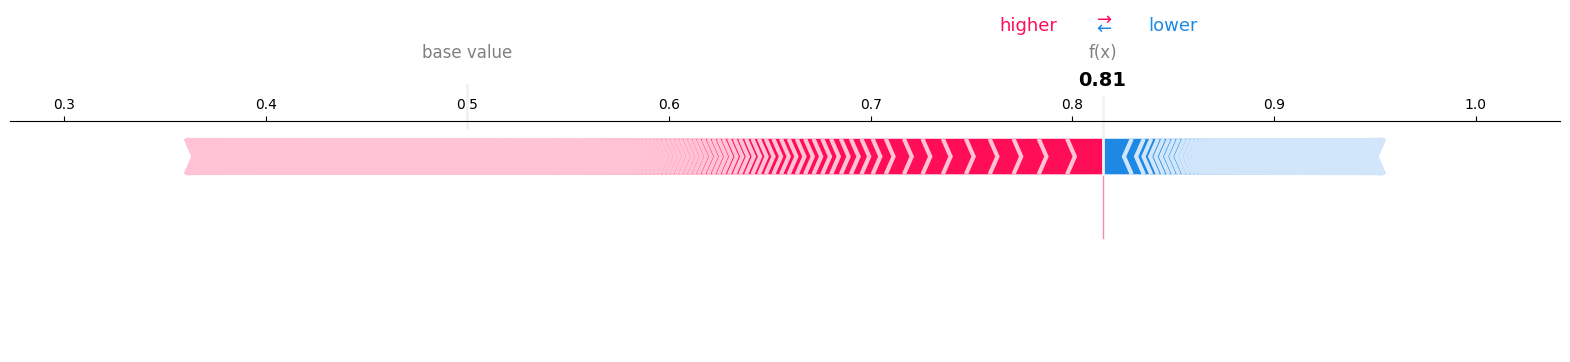


--- Example index 98, true label: Positive ---
Text: playing through the witcher 3 again and the novigrads quests and the atmosphere make me even more excited for the cant wait to get to the night city


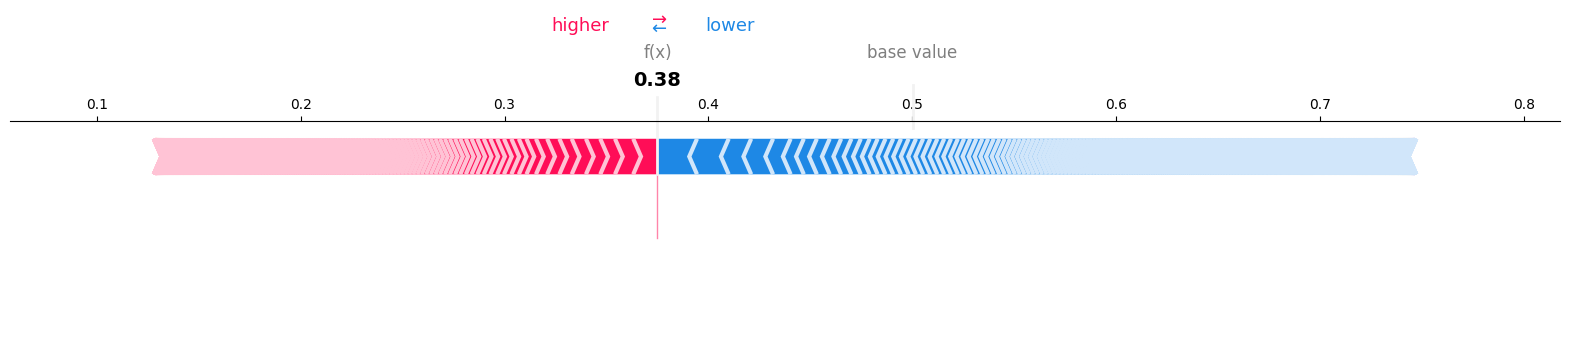


LIME explanation for index 70, text: hey why is my internet speed 360mbps down327mbps up when i pay for 1gig symmetric services verizonfios fiosfail speedtest fiosfam test is performed over a wired connection with cat8 sftp 40gb cables speedtestnetresultc7cf7b



LIME explanation for index 98, text: playing through the witcher 3 again and the novigrads quests and the atmosphere make me even more excited for the cant wait to get to the night city


In [87]:
# choose dimension from intersection
dim = result["tops"]["intersection"][0]  # e.g., dim 19 etc.

# cluster and inspect
df_cluster = cluster_high_dim_texts(
    dim_idx=dim,
    X_embeddings=X_val,
    texts=val_df["text"],
    shap_values_pos_class=shap_values[1],
    n_clusters=3,
)

# show force plots
show_force_plots_for_dim(
    dim_idx=dim,
    X_val=X_val,
    y_val=y_val,
    val_texts=val_df["text"],
    shap_values_pos_class=shap_values[1],
    explainer=explainer,
    n_examples=2,
)

# show LIME for same indices
rep_idxs = get_representative_indices(dim, X_val, shap_values[1], y_val, top_n=2)
for idx in rep_idxs:
    show_lime_for_example(idx, rf, X_val, val_df["text"])

In [88]:
perm_res = permutation_importance(rf, X_val, y_val, n_repeats=20, random_state=42, scoring="roc_auc", n_jobs=-1)
perm_importances = perm_res.importances_mean
rank_perm = np.argsort(perm_importances)[::-1].tolist().index(dim) + 1
print(f"Permutation importance da dim_{dim}: {perm_importances[dim]:.5f}")
print(f"Rank da dim_{dim} em permutation importance: {rank_perm}")

Permutation importance da dim_32: 0.00025
Rank da dim_32 em permutation importance: 17
